# Dask & multiprocessing

```
conda install dask distributed -c conda-forge
```

_(and numpy, matplotlib from before)_

Computers aren't getting any _faster._

<center><img src="img/clock-rate.jpg" width="60%" /><div style="font-size: 14px"><i>Computer Architecture: A Quantitative Approach,</i> David A. Patterson and John L. Hennessy</div></center>

But Moore's Law is still in effect: the number of transistors per square inch continues to grow exponentially (for now). In the 21st century, however, those extra transitors are used to make more execution units, not to incrase the rate through smaller pipelines.

(The scaling of clock rates— Dennard's Law— ended because power dissipation scales with clock rate squared: anything faster than 3 GHz _cooks_ the chip!)

Most programming languages, Python among them, cannot be transparently parallelized. You'll have to change your programs to use the extra processors.

Let's take a moderately complex problem as an example.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import time

def prepare(height, width):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.zeros(c.shape, dtype=numpy.int32)
    return c, fractal

def run(c, fractal, maxiterations=20):
    fractal *= 0                  # set fractal to maxiterations without replacing it
    fractal += maxiterations
    z = c
    for i in range(maxiterations):
        z = z**2 + c
        diverge = numpy.absolute(z) > 2
        divnow = diverge & (fractal == maxiterations)
        fractal[divnow] = i
        z[diverge] = 2
    return fractal

In [2]:
c, fractal = prepare(8000, 12000)

starttime = time.time()
fractal = run(c, fractal)
time.time() - starttime

37.43777847290039

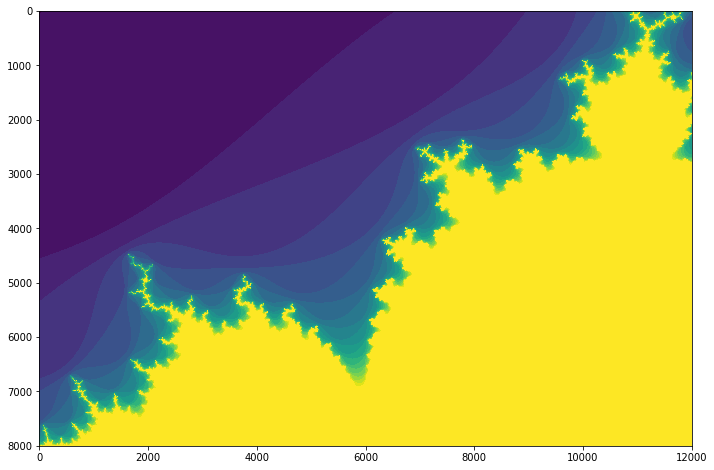

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(fractal)
# ax.imshow(fractal[-2000:, :3000])

Python has built-in libraries for parallel processing:

   * **threading:** lets you launch individual threads; you manage coordination.
   * **multiprocessing:** same interface but it launches processes. Pro: can't make common mistakes due to shared memory. Con: memory isn't shared; have to ship data to and from workers.
   * **concurrent.futures:** higher-level interface: Python manages workers; you send work.

Here's an illustration of the threading interface. Since memory is shared, we don't have to send data to the workers or send results back— they can all see and modify the same array.

In [4]:
import threading

class Worker(threading.Thread):
    def __init__(self, c, fractal, i):
        super(Worker, self).__init__()
        self.c, self.fractal, self.i = c, fractal, i
    def run(self):
        run(self.c[10*self.i : 10*(self.i + 1), :], self.fractal[10*self.i : 10*(self.i + 1), :])

c, fractal = prepare(8000, 12000)
workers = []
for i in range(800):
    workers.append(Worker(c, fractal, i))

starttime = time.time()

for worker in workers:
    worker.start()
for worker in workers:
    worker.join()

time.time() - starttime

12.832772731781006

Now we have to check the result because it's easy to screw this up. (I did many times, preparing this talk.)

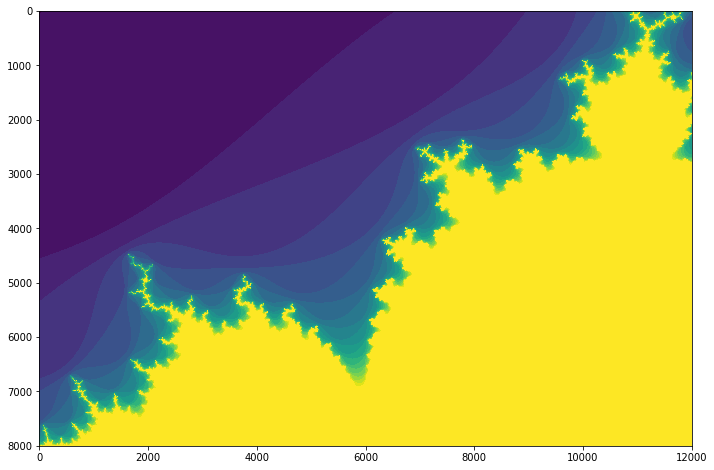

In [5]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(fractal)

1 thread took 35 seconds to complete.

8 threads took 12 seconds to complete.

In [6]:
35 / 12

2.9166666666666665

3 ≠ 8.

It's often difficult to get "perfect scaling," N times more work from N threads, in real situations. Even though this problem is "embarrassingly parallel" (none of the workers need to know other workers' results), there can be scheduling overhead, contention for memory, or slow-downs due to Python's [Global Interpreter Lock](https://realpython.com/python-gil/).

One way to avoid the global interpreter lock is to send work to separate processes. Python interpreters in separate processes do not share memory and therefore do not need to coordinate.

However, that means that we can't send data by simply sharing variables. We have to send it through a `multiprocessing.Queue` (which serializes— pickles— the data so that it can go through a pipe).

...usually. There's an exception to this: you can share arrays among processes if you declare them as shared memory before launching the subprocesses. Python has a special type for this:

In [7]:
import multiprocessing
import ctypes

sharedarray = multiprocessing.RawArray(ctypes.c_double, 100)
sharedarray

This is not a Numpy array, but it can be cast as a Numpy array (in the forked process) like this:

In [8]:
numpy.frombuffer(sharedarray, dtype=numpy.float64)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

If the forked processes are not writing to different parts of the array, they can seriously garble the data if they write to the same element at the same time.


It's not for the faint of heart, but it can be the fastest way to communicate between processes, and seperate processes are the only way to fully escape synchronization delays due to Python's global interpreter lock.

By now, you may be wondering if there's a more "high level" approach.

Python 3 introduced an "executor" interface that manages workers for you. Instead of creating threads or processes with a `run` method, you create an executor and send work to it.

In [9]:
import concurrent.futures
executor = concurrent.futures.ThreadPoolExecutor(max_workers=8)

In [10]:
c, fractal = prepare(8000, 12000)
# fractal = numpy.asfortranarray(fractal)

def piece(i):
    ci =       c[10*i : 10*(i + 1), :]
    fi = fractal[10*i : 10*(i + 1), :]
    run(ci, fi)

starttime = time.time()

futures = executor.map(piece, range(800))
for future in futures:         # iterating over them waits for the results
    pass

time.time() - starttime

10.730626583099365

Yay! A tiny bit better! What happens when we change to Fortran order? Why?

Always make sure we haven't screwed things up.

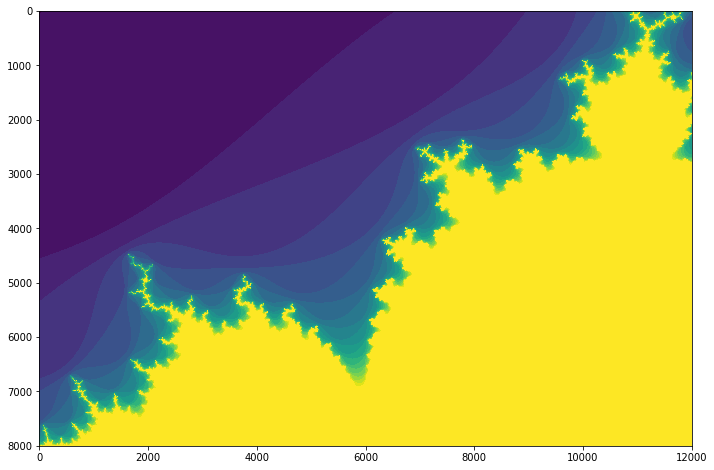

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(fractal)

Still, there needs to be a better way. Our array slices in `piece` are fragile: an indexing error can ruin the result. Can't the problem of scattering work be generalized?

In [12]:
import dask.array

In [13]:
c, fractal = prepare(8000, 12000)

c = dask.array.from_array(c, chunks=(10, 12000))
fractal = dask.array.from_array(fractal, chunks=(10, 12000))

starttime = time.time()
fractal = run(c, fractal)
time.time() - starttime

0.1613941192626953

That was too fast: too good to be true.

In [14]:
fractal

dask.array<where, shape=(8000, 12000), dtype=int32, chunksize=(10, 12000)>

This is not an array: it is a description of how to make an array. Dask has stepped through our procedure and built an execution graph, encoding all the dependencies so that it can correctly apply it to individual chunks. When we execute this graph, Dask will send a chunk to each processor in the computer and combine results.

In [15]:
starttime = time.time()
fractal = fractal.compute()    # replace `fractal` the execution graph with `fractal` the array result
time.time() - starttime

21.773770093917847

Now this check is a formality: Dask has managed the chunking, so we won't accidentally miss a slice.

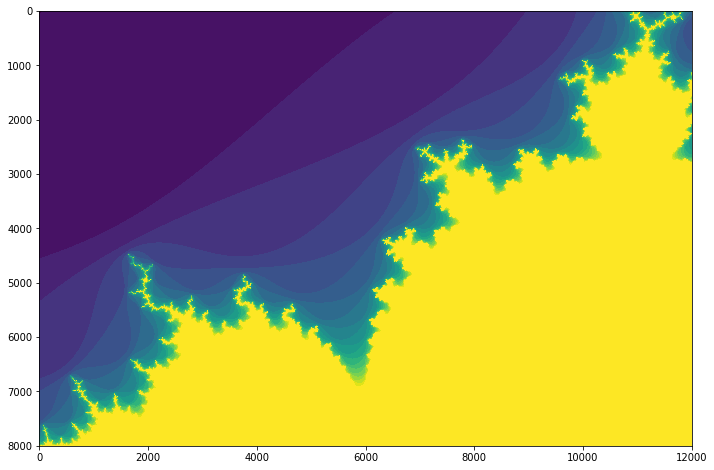

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(fractal)

We seem to have paid for this simplicity: it took twice as long as the carefully sliced `pieces` in the executor.

The reason is that our code is not as simple as it looks. It has masking and piecemeal assignments, which in principle could introduce complex dependencies. _We_ know that everything will be fine if you just chop up the array in independent sections— and thus we implemented our thread and executor-based solutions that way.

Let me show you what Dask has to do for a 1×1 chunking of our problem.

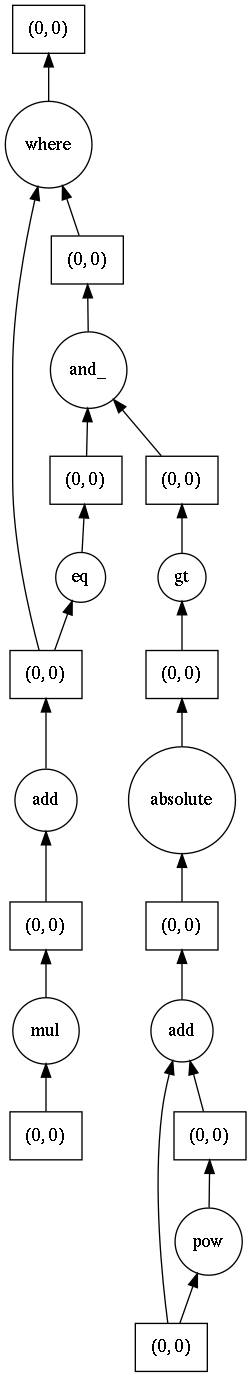

In [17]:
c, fractal = prepare(1, 1)                                 # try 2, 2
c = dask.array.from_array(c, chunks=(1, 1))
fractal = dask.array.from_array(fractal, chunks=(1, 1))
fractal = run(c, fractal, maxiterations=1)                 # try more iterations
fractal.visualize()

If that were all, I'd probably stick to chopping up the grid by hand (when possible). However, _exactly the same interface_ that distributes work across cores in my laptop can distribute work around the world, just by pointing it to a remote scheduler.

This is truly the ~~lazy~~ busy researcher approach!

Note to self: launch

`dask-scheduler &`

and

`dask-worker --nthreads 8 127.0.0.1:8786 &`

in a terminal now.

In [18]:
import dask.distributed
client = dask.distributed.Client("127.0.0.1:8786")
client

Client Scheduler: tcp://127.0.0.1:8786 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 8 Memory: 11.10 GB


In [19]:
c, fractal = prepare(8000, 12000)

c = dask.array.from_array(c, chunks=(100, 12000))
fractal = dask.array.from_array(fractal, chunks=(100, 12000))
fractal = run(c, fractal)

starttime = time.time()
fractal = client.compute(fractal, sync=True)
time.time() - starttime

38.1241352558136

Well, that was exciting!

In the end, this example took longer than the single-core version, but it illustrates how array operations _can be_ distributed in a simple way.

I haven't shown very much of what Dask can do. It's a general toolkit for delayed and distributed evaluation. As such, it provides a nice way to work on Pandas-like DataFrames that are too large for memory:

In [20]:
import dask.dataframe

df = dask.dataframe.read_csv("data/nasa-exoplanets.csv")
df

,rowid,pl_hostname,pl_letter,pl_name,pl_discmethod,pl_pnum,pl_orbper,pl_orbsmax,pl_orbeccen,pl_orbincl,pl_bmassj,pl_bmassprov,pl_radj,pl_dens,pl_ttvflag,pl_kepflag,pl_k2flag,pl_nnotes,ra_str,ra,dec_str,dec,st_dist,st_optmag,st_optband,gaia_gmag,st_teff,st_mass,st_rad,rowupdate,pl_tranflag,pl_rvflag,pl_imgflag,pl_astflag,pl_omflag,pl_cbflag,pl_angsep,pl_orbtper,pl_orblper,pl_rvamp,pl_eqt,pl_insol,pl_massj,pl_msinij,pl_masse,pl_msinie,pl_bmasse,pl_rade,pl_rads,pl_trandep,pl_trandur,pl_tranmid,pl_tsystemref,pl_imppar,pl_occdep,pl_ratdor,pl_ratror,pl_def_reflink,pl_disc,pl_disc_reflink,pl_locale,pl_facility,pl_telescope,pl_instrument,pl_status,pl_mnum,pl_st_npar,pl_st_nref,pl_pelink,pl_edelink,pl_publ_date,hd_name,hip_name,st_rah,st_glon,st_glat,st_elon,st_elat,st_plx,gaia_plx,gaia_dist,st_pmra,st_pmdec,st_pm,gaia_pmra,gaia_pmdec,gaia_pm,st_radv,st_sp,st_spstr,st_logg,st_lum,st_dens,st_metfe,st_metratio,st_age,st_vsini,st_acts,st_actr,st_actlx,swasp_id,st_nts,st_nplc,st_nglc,st_nrvc,st_naxa,st_nimg,st_nspec,st_uj,st_vj,st_bj,st_rc,st_ic,st_j,st_h,st_k,st_wise1,st_wise2,st_wise3,st_wise4,st_irac1,st_irac2,st_irac3,st_irac4,st_mips1,st_mips2,st_mips3,st_iras1,st_iras2,st_iras3,st_iras4,st_photn,st_umbj,st_bmvj,st_vjmic,st_vjmrc,st_jmh2,st_hmk2,st_jmk2,st_bmy,st_m1,st_c1,st_colorn
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,object,object,object,object,int64,float64,float64,float64,float64,float64,object,float64,float64,int64,int64,int64,int64,object,float64,object,float64,float64,float64,object,float64,float64,float64,float64,object,int64,int64,int64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,object,int64,object,object,object,object,object,int64,int64,int64,int64,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,object,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


We don't see the data because they haven't been loaded. But we can get them if we need them.

In [21]:
df[["pl_hostname", "pl_pnum"]].compute()

,pl_hostname,pl_pnum
0,11 Com,1
1,11 UMi,1
2,14 And,1
3,14 Her,1
4,16 Cyg B,1
5,18 Del,1
6,1RXS J160929.1-210524,1
7,24 Boo,1
8,24 Sex,2
9,24 Sex,2


Additionally, Dask isn't the only project filling this need. There's also:

   * **Joblib:** annotate functions to execute remotely with decorators.
   * **Parsl:** same, but work with conventional schedulers (Condor, Slurm, GRID); an academic project.
   * **PySpark:** Spark is a big, scalable project, though its Python interface has performance issues.

and many smaller projects.

(Distributed computing hasn't been fully figured out yet.)